<a href="https://www.kaggle.com/code/kenny3s/iht-pyiqa-sadcnn?scriptVersionId=152501877" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import os
data_dir = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"
re_dir = "/kaggle/input/lfw-re-sadcnn"
iht_dir = '/kaggle/input/lfw-iht'
p = []
for person in os.listdir(iht_dir):
    p.append(person)
p

['Colin_Powell',
 'Jean_Chretien',
 'Hugo_Chavez',
 'Gerhard_Schroeder',
 'John_Ashcroft',
 'Donald_Rumsfeld',
 'Ariel_Sharon',
 'Jacques_Chirac',
 'George_W_Bush',
 'Serena_Williams',
 'Tony_Blair',
 'Junichiro_Koizumi']

In [1]:
!pip install pyiqa
#https://www.kaggle.com/discussions/questions-and-answers/426884
!sed -i 's/from scipy.spatial import ConvexHull, QhullError/from scipy.spatial import ConvexHull/g' /opt/conda/lib/python3.10/site-packages/skimage/morphology/convex_hull.py

  Obtaining dependency information for pyiqa from https://files.pythonhosted.org/packages/c6/ae/bff1d01ccb94051b8c06c152680336aa142174f80917968015e8b6dcc2d7/pyiqa-0.1.8-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 6.6 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for tb-nightly from https://files.pythonhosted.org/packages/cd/30/5b8d92d617603faa47e1587c1120670f5f721f25efb56259ef0fb4fdd7b4/tb_nightly-2.16.0a20231126-py3-none-any.whl.metadata
  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-an

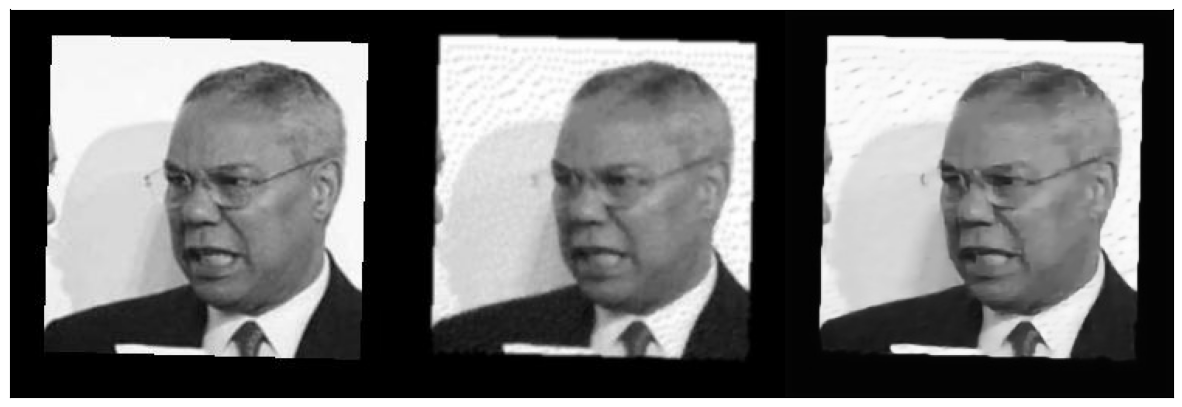

In [4]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
for person in p[:1]:
    for img in os.listdir(os.path.join(data_dir, person))[:1]:
        color = Image.open(f"{data_dir}/{person}/{img}")
        iht = Image.open(f"{iht_dir}/{person}/{img}")  # Assuming this returns a NumPy array
        sa = Image.open(f"{re_dir}/{person}/{img}")
        
        color = color.convert('L').convert("RGB")
        iht = iht.convert("RGB")
        sa = sa.convert("RGB")
        
        # Convert the images to NumPy arrays and stack them horizontally
        rst = np.hstack([np.array(color), np.array(iht), np.array(sa)])

        # Convert the result back to a PIL image
        rst = Image.fromarray(rst)

        plt.figure(figsize=(15, 15))  
        plt.xticks([]) 
        plt.yticks([]) 
        plt.imshow(rst)
        plt.show()


In [5]:
import os
import torch
from PIL import Image
import pyiqa

from tqdm import tqdm
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

psnr_metric = pyiqa.create_metric('psnr', device=device)
ssim_metric = pyiqa.create_metric('ssim', device=device)
clip_metric = pyiqa.create_metric('clipiqa+', device=device)
ms_ssim_metric = pyiqa.create_metric('ms_ssim', device=device)
lpips_metric = pyiqa.create_metric('lpips', device=device)
dists_metric = pyiqa.create_metric('dists', device=device)
fid_metric = pyiqa.create_metric('fid', device=device)

def calculate_quality(x, y, z):
    quality = {
        'psnr1': psnr_metric(x, y).item(),
        'psnr2': psnr_metric(x, z).item(),
        'ssim1': ssim_metric(x, y).item(),
        'ssim2': ssim_metric(x, z).item(),
        "ms_ssim1": ms_ssim_metric(x, y).item(),
        "ms_ssim2": ms_ssim_metric(x, z).item(),
        "clip_iqa1": clip_metric(y).item(),
        "clip_iqa2": clip_metric(z).item(),
        "lpips1": lpips_metric(x, y).item(),
        "lpips2": lpips_metric(x, z).item(),
        "dists1": dists_metric(x, y).item(),
        "dists2": dists_metric(x, z).item(),
    }

    return quality

def calculate_fid(x, y, z):
    quality = {
        'fid1': fid_metric(x, y).item(),
        'fid2': fid_metric(x, z).item(),
    }
    return quality

# Initialize a dictionary to store the average quality for each class
average_quality = {}

for person in p:
    quality_sum = {}
    fid_sum = {}
    
    quality_fid = calculate_fid(f"{data_dir}/{person}",f"{iht_dir}/{person}",f"{re_dir}/{person}" )
    for key, value in quality_fid.items():
        fid_sum[key] = quality_sum.get(key, 0) + value
        
    for img in os.listdir(os.path.join(data_dir, person)):
        color = Image.open(f"{data_dir}/{person}/{img}")
        iht = Image.open(f"{iht_dir}/{person}/{img}") 
        sa = Image.open(f"{re_dir}/{person}/{img}")
        
        color = color.convert('L').convert("RGB")
        iht = iht.convert("RGB")
        sa = sa.convert("RGB")

        # Calculate the quality for this image
        quality = calculate_quality(color, iht, sa)

        # Update the sum of the quality
        for key, value in quality.items():
            quality_sum[key] = quality_sum.get(key, 0) + value
    
    
    # Calculate the average quality for this class
    num_images = len(os.listdir(os.path.join(data_dir, person)))
    average_quality[person] = {key: value / num_images for key, value in quality_sum.items()}
    average_quality[person].update({key: value for key, value in fid_sum.items()})


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-27 06:03:51,531 INFO: Metric [PSNR] is created.
2023-11-27 06:03:51,532 INFO: Metric [SSIM] is created.
100%|████████████████████████████████████████| 244M/244M [00:02<00:00, 118MiB/s]


Downloading: "https://github.com/chaofengc/IQA-PyTorch/releases/download/v0.1-weights/CLIP-IQA+_learned_prompts-603f3273.pth" to /root/.cache/torch/hub/checkpoints/CLIP-IQA+_learned_prompts-603f3273.pth



100%|██████████| 16.7k/16.7k [00:00<00:00, 10.2MB/s]
2023-11-27 06:04:00,458 INFO: Metric [CLIPIQA] is created.
2023-11-27 06:04:00,460 INFO: Metric [MS_SSIM] is created.
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 143MB/s]  


Downloading: "https://github.com/chaofengc/IQA-Toolbox-Python/releases/download/v0.1-weights/LPIPS_v0.1_alex-df73285e.pth" to /root/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth



100%|██████████| 5.87k/5.87k [00:00<00:00, 5.28MB/s]
2023-11-27 06:04:03,359 INFO: Metric [LPIPS] is created.


Loading pretrained model LPIPS from /root/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 259MB/s]  


Downloading: "https://github.com/chaofengc/IQA-PyTorch/releases/download/v0.1-weights/DISTS_weights-f5e65c96.pth" to /root/.cache/torch/hub/checkpoints/DISTS_weights-f5e65c96.pth



100%|██████████| 12.0k/12.0k [00:00<00:00, 4.97MB/s]
2023-11-27 06:04:07,450 INFO: Metric [DISTS] is created.
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading pretrained model DISTS from /root/.cache/torch/hub/checkpoints/DISTS_weights-f5e65c96.pth
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth



100%|██████████| 91.2M/91.2M [00:00<00:00, 243MB/s] 
2023-11-27 06:04:08,575 INFO: Metric [FID] is created.


Loading pretrained model Inception3 from /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
compute FID between two folders


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Found 236 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Colin_Powell


FID Colin_Powell: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Found 236 images in the folder /kaggle/input/lfw-iht/Colin_Powell


FID Colin_Powell: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]


compute FID between two folders
Found 236 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Colin_Powell


FID Colin_Powell: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


Found 236 images in the folder /kaggle/input/lfw-re-sadcnn/Colin_Powell


FID Colin_Powell: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]


compute FID between two folders
Found 55 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Jean_Chretien


FID Jean_Chretien: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Found 55 images in the folder /kaggle/input/lfw-iht/Jean_Chretien


FID Jean_Chretien: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


compute FID between two folders
Found 55 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Jean_Chretien


FID Jean_Chretien: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Found 55 images in the folder /kaggle/input/lfw-re-sadcnn/Jean_Chretien


FID Jean_Chretien: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


compute FID between two folders
Found 71 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Hugo_Chavez


FID Hugo_Chavez: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Found 71 images in the folder /kaggle/input/lfw-iht/Hugo_Chavez


FID Hugo_Chavez: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


compute FID between two folders
Found 71 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Hugo_Chavez


FID Hugo_Chavez: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Found 71 images in the folder /kaggle/input/lfw-re-sadcnn/Hugo_Chavez


FID Hugo_Chavez: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


compute FID between two folders
Found 109 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Gerhard_Schroeder


FID Gerhard_Schroeder: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Found 109 images in the folder /kaggle/input/lfw-iht/Gerhard_Schroeder


FID Gerhard_Schroeder: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


compute FID between two folders
Found 109 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Gerhard_Schroeder


FID Gerhard_Schroeder: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Found 109 images in the folder /kaggle/input/lfw-re-sadcnn/Gerhard_Schroeder


FID Gerhard_Schroeder: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


compute FID between two folders
Found 53 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/John_Ashcroft


FID John_Ashcroft: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Found 53 images in the folder /kaggle/input/lfw-iht/John_Ashcroft


FID John_Ashcroft: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


compute FID between two folders
Found 53 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/John_Ashcroft


FID John_Ashcroft: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


Found 53 images in the folder /kaggle/input/lfw-re-sadcnn/John_Ashcroft


FID John_Ashcroft: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


compute FID between two folders
Found 121 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Donald_Rumsfeld


FID Donald_Rumsfeld: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Found 121 images in the folder /kaggle/input/lfw-iht/Donald_Rumsfeld


FID Donald_Rumsfeld: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


compute FID between two folders
Found 121 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Donald_Rumsfeld


FID Donald_Rumsfeld: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Found 121 images in the folder /kaggle/input/lfw-re-sadcnn/Donald_Rumsfeld


FID Donald_Rumsfeld: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


compute FID between two folders
Found 77 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Ariel_Sharon


FID Ariel_Sharon: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Found 77 images in the folder /kaggle/input/lfw-iht/Ariel_Sharon


FID Ariel_Sharon: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


compute FID between two folders
Found 77 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Ariel_Sharon


FID Ariel_Sharon: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Found 77 images in the folder /kaggle/input/lfw-re-sadcnn/Ariel_Sharon


FID Ariel_Sharon: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


compute FID between two folders
Found 52 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Jacques_Chirac


FID Jacques_Chirac: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Found 52 images in the folder /kaggle/input/lfw-iht/Jacques_Chirac


FID Jacques_Chirac: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


compute FID between two folders
Found 52 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Jacques_Chirac


FID Jacques_Chirac: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Found 52 images in the folder /kaggle/input/lfw-re-sadcnn/Jacques_Chirac


FID Jacques_Chirac: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


compute FID between two folders
Found 530 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/George_W_Bush


FID George_W_Bush: 100%|██████████| 17/17 [00:03<00:00,  5.44it/s]


Found 530 images in the folder /kaggle/input/lfw-iht/George_W_Bush


FID George_W_Bush: 100%|██████████| 17/17 [00:03<00:00,  5.20it/s]


compute FID between two folders
Found 530 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/George_W_Bush


FID George_W_Bush: 100%|██████████| 17/17 [00:03<00:00,  5.48it/s]


Found 530 images in the folder /kaggle/input/lfw-re-sadcnn/George_W_Bush


FID George_W_Bush: 100%|██████████| 17/17 [00:03<00:00,  5.61it/s]


compute FID between two folders
Found 52 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Serena_Williams


FID Serena_Williams: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Found 52 images in the folder /kaggle/input/lfw-iht/Serena_Williams


FID Serena_Williams: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


compute FID between two folders
Found 52 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Serena_Williams


FID Serena_Williams: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Found 52 images in the folder /kaggle/input/lfw-re-sadcnn/Serena_Williams


FID Serena_Williams: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


compute FID between two folders
Found 144 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Tony_Blair


FID Tony_Blair: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Found 144 images in the folder /kaggle/input/lfw-iht/Tony_Blair


FID Tony_Blair: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


compute FID between two folders
Found 144 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Tony_Blair


FID Tony_Blair: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Found 144 images in the folder /kaggle/input/lfw-re-sadcnn/Tony_Blair


FID Tony_Blair: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


compute FID between two folders
Found 60 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Junichiro_Koizumi


FID Junichiro_Koizumi: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Found 60 images in the folder /kaggle/input/lfw-iht/Junichiro_Koizumi


FID Junichiro_Koizumi: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


compute FID between two folders
Found 60 images in the folder /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Junichiro_Koizumi


FID Junichiro_Koizumi: 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Found 60 images in the folder /kaggle/input/lfw-re-sadcnn/Junichiro_Koizumi


FID Junichiro_Koizumi: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


## 后缀为1代表IHT逆半调
## 后缀为2代表SADCNN逆半调

In [6]:
import pandas as pd

# Convert the dictionary to a DataFrame
df = pd.DataFrame(average_quality)

# Transpose the DataFrame so that each row corresponds to a person
df = df.transpose()

# Display the DataFrame
print(df)

# Save the DataFrame as a CSV file
df.to_csv('quality_metrics.csv')

                       psnr1      psnr2     ssim1     ssim2  ms_ssim1  \
Colin_Powell       30.715662  32.430234  0.882977  0.864352  0.970902   
Jean_Chretien      31.847206  33.216261  0.884694  0.896302  0.970949   
Hugo_Chavez        30.663944  32.490054  0.886414  0.896877  0.972359   
Gerhard_Schroeder  31.297106  32.911177  0.894691  0.897521  0.973965   
John_Ashcroft      31.132868  32.814307  0.888936  0.889776  0.972961   
Donald_Rumsfeld    31.005684  32.598333  0.888757  0.895056  0.973707   
Ariel_Sharon       30.950983  32.731792  0.876989  0.883687  0.968418   
Jacques_Chirac     31.250449  32.680872  0.883065  0.883601  0.967861   
George_W_Bush      31.225895  32.888725  0.880351  0.895843  0.970757   
Serena_Williams    31.225407  32.694258  0.897667  0.902390  0.976050   
Tony_Blair         31.538500  33.197529  0.881182  0.901548  0.969282   
Junichiro_Koizumi  30.415188  32.338437  0.888058  0.874871  0.973811   

                   ms_ssim2  clip_iqa1  clip_iqa2 

## 基于LFW数据集中大于50图像的人脸
- 实线表示滤波器逆半色调图像质量
- 虚线表示结构感知网络逆半色调图像质量
- LPIPS、DISTS、FID 是 lower-best IQA指标
- 右侧刻度用于PSNR与FID指标

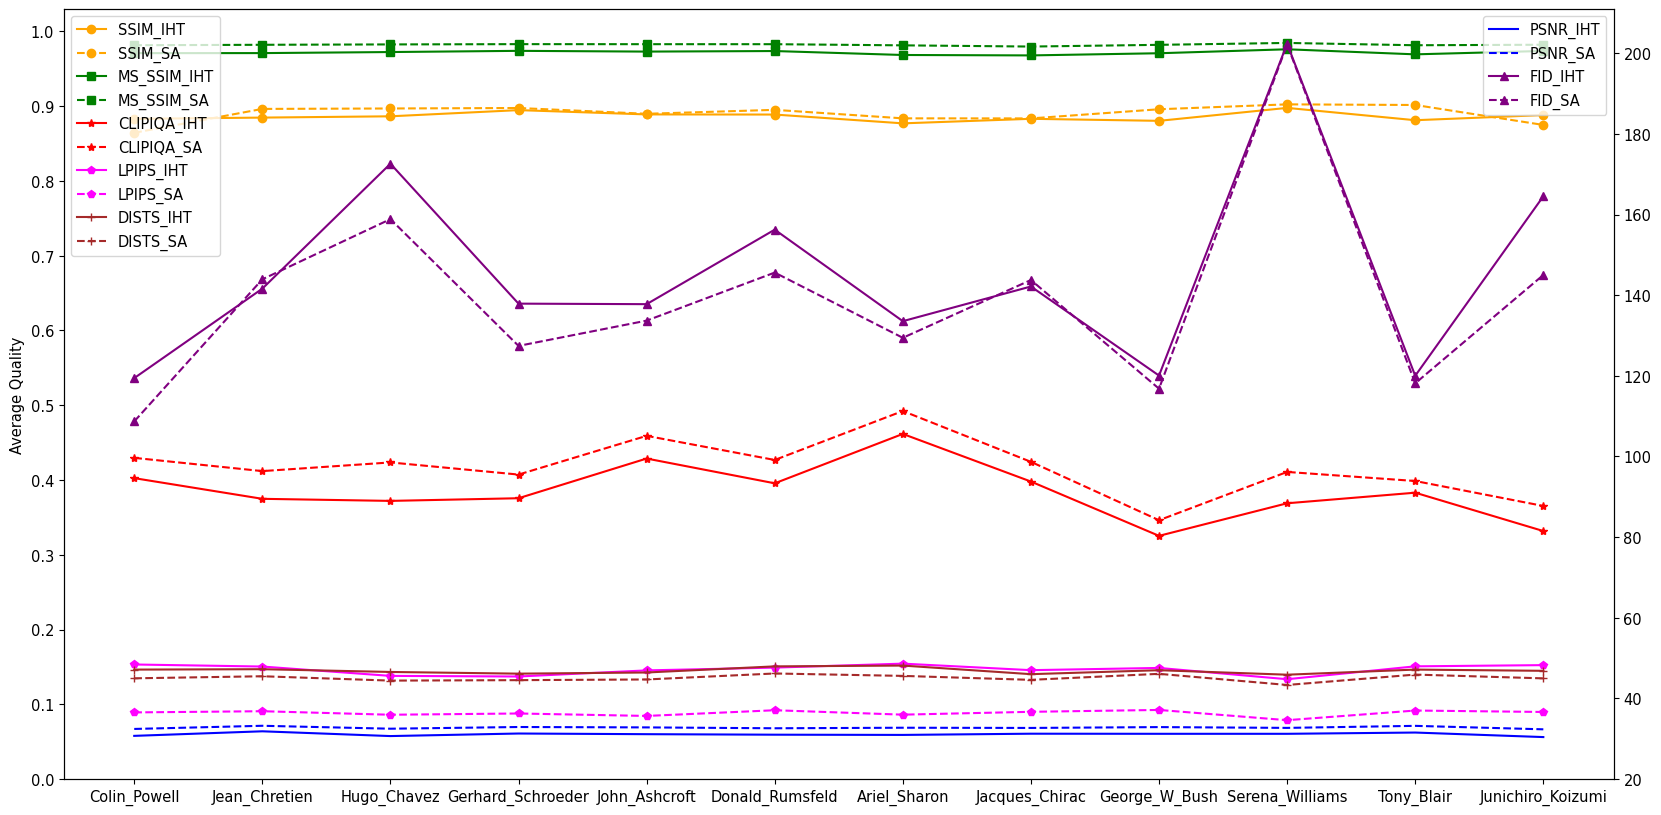

In [7]:
# Set the global font to be Times New Roman, 10.5pt size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5

fig, ax1 = plt.subplots(figsize=(20, 10))

ax2 = ax1.twinx()
ax2.plot(list(average_quality.keys()), [quality['psnr1'] for quality in average_quality.values()], '-',  color='blue',label='PSNR_IHT')
ax2.plot(list(average_quality.keys()), [quality['psnr2'] for quality in average_quality.values()], '--',  color='blue',label='PSNR_SA')

ax1.plot(list(average_quality.keys()), [quality['ssim1'] for quality in average_quality.values()], '-o', color='orange', label='SSIM_IHT')
ax1.plot(list(average_quality.keys()), [quality['ssim2'] for quality in average_quality.values()], '--o', color='orange', label='SSIM_SA')

ax1.plot(list(average_quality.keys()), [quality['ms_ssim1'] for quality in average_quality.values()], '-s', color='green', label='MS_SSIM_IHT')
ax1.plot(list(average_quality.keys()), [quality['ms_ssim2'] for quality in average_quality.values()], '--s', color='green', label='MS_SSIM_SA')

ax1.plot(list(average_quality.keys()), [quality['clip_iqa1'] for quality in average_quality.values()], '-*', color='red', label='CLIPIQA_IHT')
ax1.plot(list(average_quality.keys()), [quality['clip_iqa2'] for quality in average_quality.values()], '--*', color='red', label='CLIPIQA_SA')

ax2.plot(list(average_quality.keys()), [quality['fid1'] for quality in average_quality.values()], '-^', color='purple', label='FID_IHT')
ax2.plot(list(average_quality.keys()), [quality['fid2'] for quality in average_quality.values()], '--^', color='purple', label='FID_SA')

ax1.plot(list(average_quality.keys()), [quality['lpips1'] for quality in average_quality.values()], '-p', color='magenta', label='LPIPS_IHT')
ax1.plot(list(average_quality.keys()), [quality['lpips2'] for quality in average_quality.values()], '--p', color='magenta', label='LPIPS_SA')

ax1.plot(list(average_quality.keys()), [quality['dists1'] for quality in average_quality.values()], '-+', color='brown', label='DISTS_IHT')
ax1.plot(list(average_quality.keys()), [quality['dists2'] for quality in average_quality.values()], '--+', color='brown', label='DISTS_SA')

# Add labels to the y-axes
ax1.set_ylabel('Average Quality')

# Add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks for ax1
ax2.set_yticks([i for i in range(20, 220, 20)])  # Set y-ticks for ax2

plt.savefig('my_figure.png', dpi=300)
plt.show()